In [1]:
import SimAnn as SA
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from generate_data import generate_data
import numpy as np
import sys
import time
import seaborn as sns
import time 
from matplotlib import cm
import pandas as pd




In [3]:
class Optimizer:

    def __init__(self, n, seed=None, create_path = False):

        if seed:
            np.random.seed(seed)

        self.data = generate_data(n, "3233248")
        self.n = n
        self.config = self.init_config()  #{x: , y:}
        self.path = []
        self.create_path =  create_path

    def init_config(self):

        # TODO: Check this covers all possible combinations (i.e even borders)
        return {"x": np.random.randint(0, self.n-1), "y": np.random.randint(0, self.n-1)}

    def cost(self):

        x_t, y_t = self.config["x"], self.config["y"]

        return self.data[x_t, y_t]

    def propose_move(self):
        
        n = self.n
        move_x = 0
        move_y = 0
        while move_x == 0 and move_y == 0:
            move_x = np.random.choice([-1, 0, 1])
            move_y = np.random.choice([-1, 0, 1])
        
       
        x_prop = (self.config["x"] + move_x)%n
        
        y_prop = (self.config["y"] + move_y)%n 

        return (x_prop, y_prop)

    def accept_move(self, move, beta):

        x_prop, y_prop = move

        self.config["x"] = x_prop
        self.config["y"] = y_prop
        
        if self.create_path:
            self.path.append([x_prop, y_prop, self.data[x_prop, y_prop], beta])

    def compute_delta_cost(self, move):

        x_prop, y_prop = move
        x_t, y_t = self.config["x"], self.config["y"]

        return self.data[x_prop, y_prop] - self.data[x_t, y_t]

    def display(self):

        plt.clf()
        ax = plt.axes(projection='3d')

        x = np.arange(self.n)
        y = np.arange(self.n)

        X, Y = np.meshgrid(x, y)

        z = self.data
        
        if self.create_path: 
            self.path = list(zip(*self.path))
            
            cmap = cm.viridis

            ax.scatter(self.path[0], self.path[1], self.path[2], s = 5, c = self.path[3], cmap=cmap)
            
        ax.plot_surface(Y, X, z, alpha=0.5)
        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        ax.set_zlabel("z-axis")

    def copy(self):
        return self.config


In [3]:
def early_stop_hook(best_c):
    if best_c < -100:
        return False 

### temperature changes

In [9]:
optimizer = Optimizer(400, create_path = False)
true_min = np.min(optimizer.data)
true_min

-103.16814252317545

In [241]:
starting_betas = [1, 0.5, 0.30, 0.1, 0.01, 0.001]



simulations = 1
anneal_steps = 1000
mcmc_steps = 100
problem_size = 500

data_raw = [] #columns are: beta0, 

optimizer = Optimizer(problem_size, create_path = False)
true_min = np.min(optimizer.data)

#LINEAR BETA
i = 0
data = np.zeros((len(starting_betas) * simulations * anneal_steps, 8))

for beta0 in starting_betas: 
    
    for sim in range(simulations):
        
        beta_list = SA.linearbeta(beta0=beta0, beta1=1*(beta0*100), steps=anneal_steps)
        _, hist = SA.simann(optimizer, mcmc_steps=100,
                             beta_list=beta_list, seed=10)
        
        data[i:i+len(hist), 0] = beta0
        data[i:i+len(hist), 1] = sim
        data[i:i+len(hist), 2] = range(0,anneal_steps)
        data[i:i+len(hist), 3:] = hist
        
        i += anneal_steps
        

In [242]:
hist_column = ["beta0", "Simulation", "Epoch", "Acceptance_rate", "Temperature", "Beta", "Current_cost", "Best_cost"]
hist_df = pd.DataFrame(data=data, columns=hist_column)


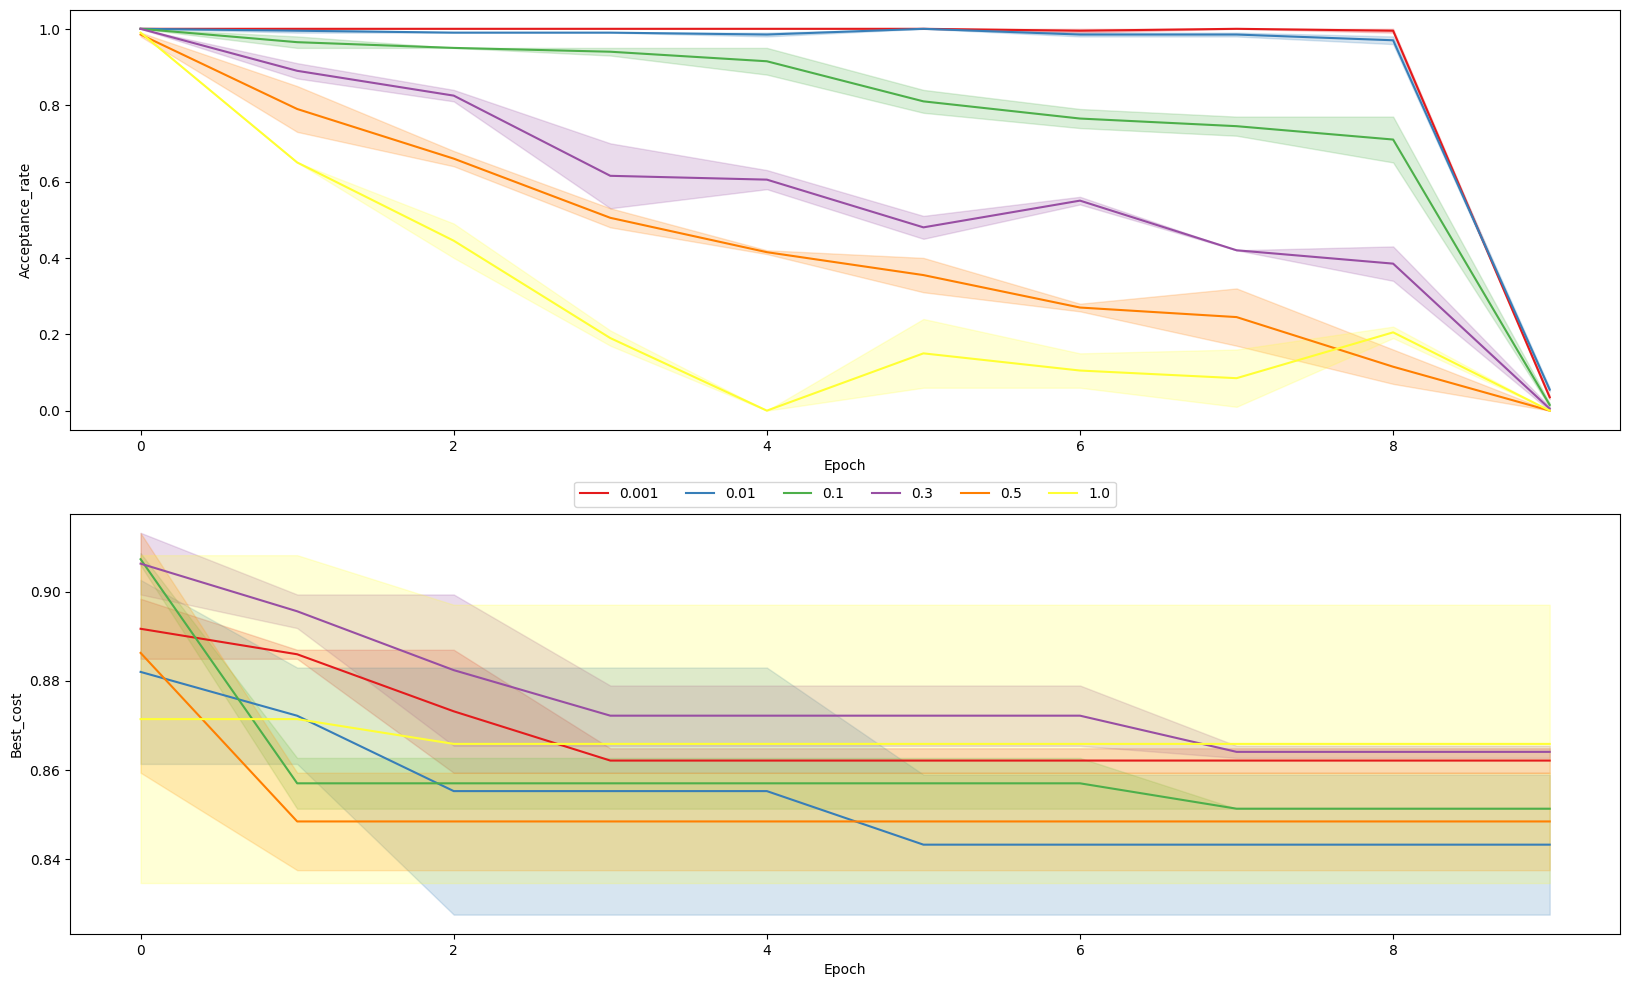

In [243]:
fig, (ax0, ax1) = plt.subplots(2,1)
fig.set_size_inches(20, 12)

#sns.lineplot(data = hist_df, x = "Epoch", y = "Temperature", ax = ax0, label = "Temperature")
sns.lineplot(data = hist_df, x = "Epoch", y = "Acceptance_rate", ax = ax0, color = "red", hue= "beta0", palette='Set1')
ax0.legend(loc='lower center', ncol = 6, bbox_to_anchor = (0.5, -0.2))

sns.lineplot(data = hist_df, x = "Epoch", y = "Best_cost", ax = ax1, hue= "beta0", palette='Set1')
ax1.legend().remove()


### Varying Problem Size

In [44]:
#problem_sizes = [100, 200, 500, 1000, 5000]

problem_sizes = [100, 200, 500, 1000, 5000]

simulations = 10
anneal_steps = 100
mcmc_steps = 100

data = np.zeros(shape = (simulations*len(problem_sizes), 4)) #columns are: problem size, last step (i.e. step at which it converged), best cost

beta_list = SA.linearbeta(beta0=0.01, beta1=1, steps=anneal_steps)


#LINEAR BETA
i = 0
for problem_size in problem_sizes: 
    for sim in range(simulations):
        
        optimizer = Optimizer(problem_size, create_path = False)
        true_min = np.min(optimizer.data)
        
        epoch, hist = SA.simann(optimizer, mcmc_steps=100,
                             beta_list=beta_list, seed=10, mc_hook= early_stop_hook)
        
        data[i][0] = problem_size
        data[i][1] = epoch
        data[i][2] = hist[epoch-1][4] #get the last best cost
        data[i][3] = np.abs(data[i][2]-true_min)/true_min
        i += 1
        

In [46]:
data_df = pd.DataFrame(data, columns=["problem_size", "last_step", "best_cost", "convergence_error"])
data_df.to_csv("data_varying_sizes")

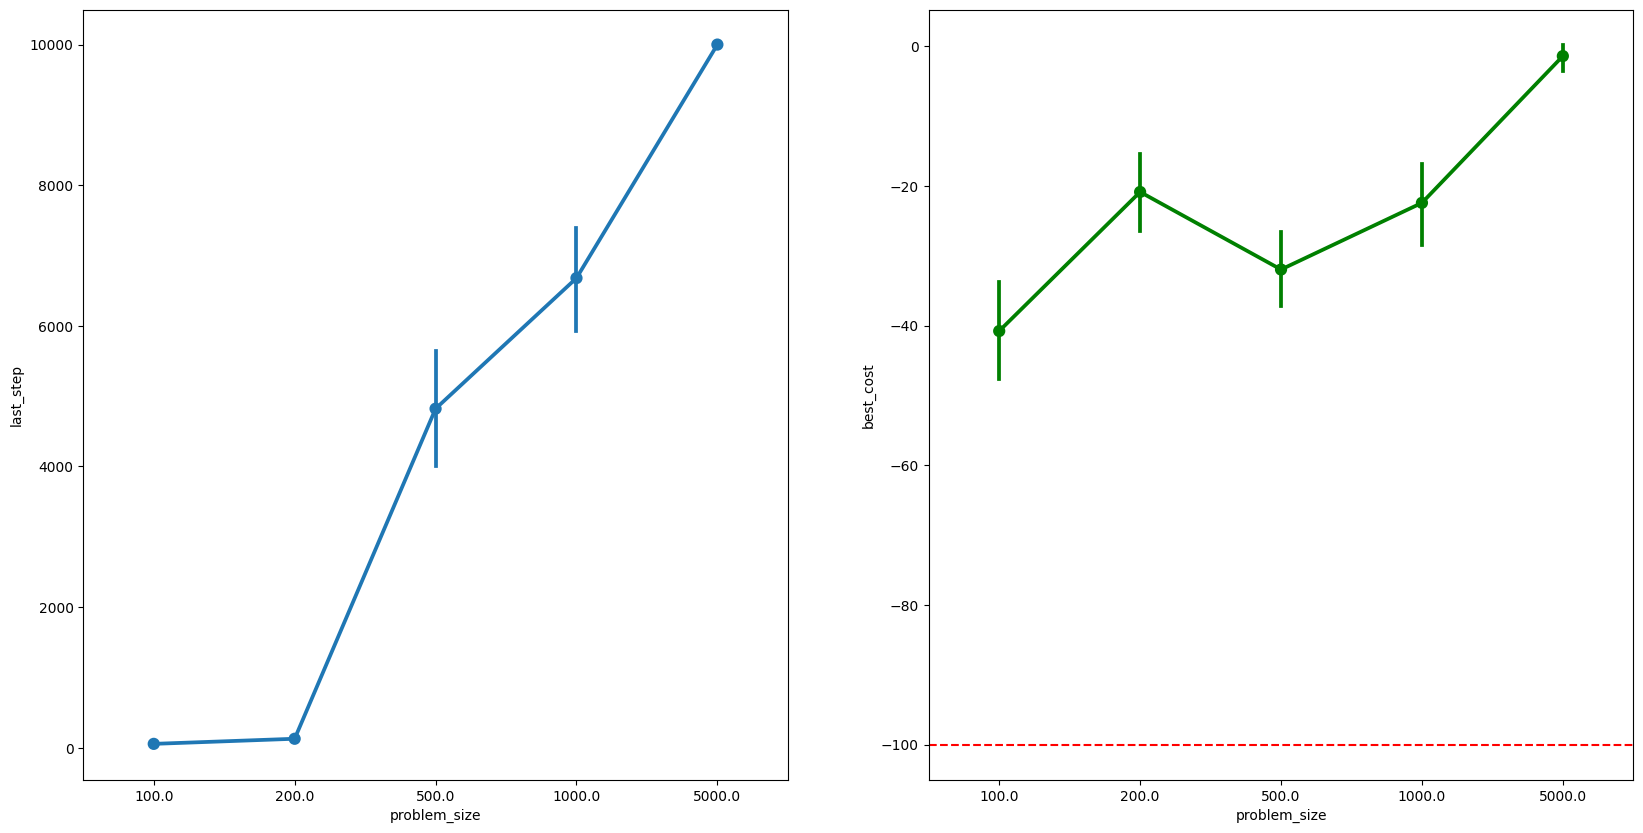

In [65]:
data_df = pd.read_csv("data_varying_sizes.csv")

fig, (ax0, ax1) = plt.subplots(1,2)
fig.set_size_inches(20,10)

sns.pointplot(data = data_df, x = "problem_size", y = "last_step", ax = ax0, label = "last step")

sns.pointplot(data = data_df, x = "problem_size", y = "best_cost", ax = ax1, color = "green", label = "convergence error")
ax1.axhline(y=-100, color='red', linestyle='--', label='Horizontal Line at -100')

plt.show()

<AxesSubplot: xlabel='epoch', ylabel='Current_cost'>

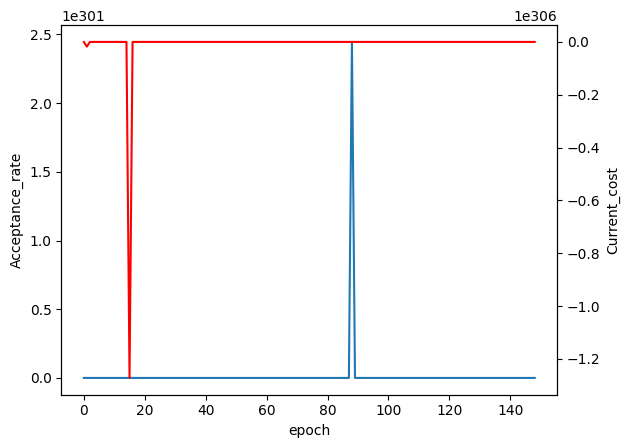

In [ ]:
sns.lineplot(data = hist[:-1], x = "epoch", y = "Acceptance_rate")
ax2 = plt.twinx()
sns.lineplot(data = hist[:-1], x = "epoch", y = "Current_cost", ax=ax2, color = "red")


### Analyzing the Landscape

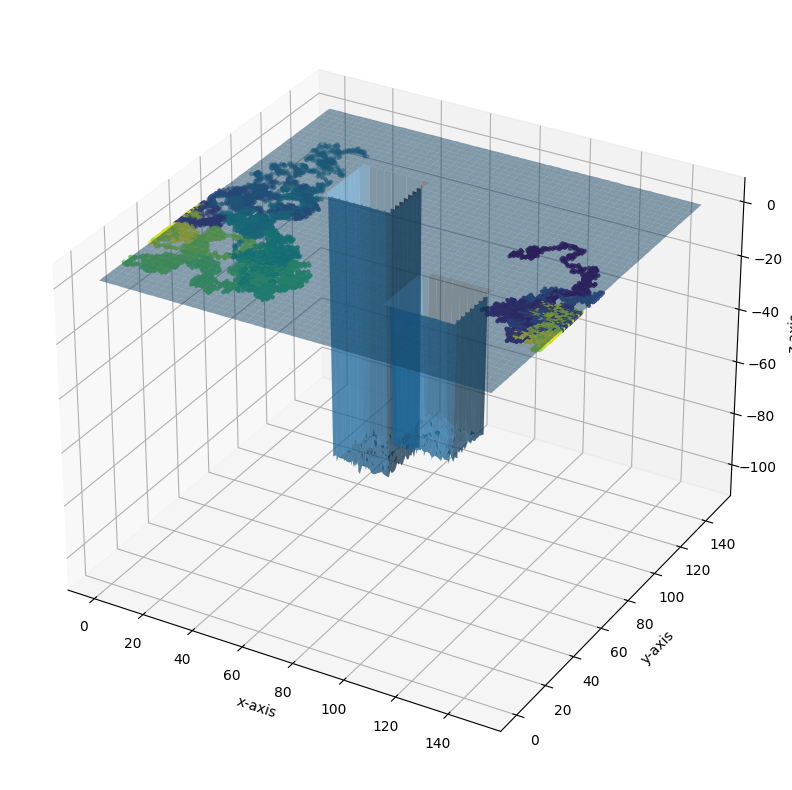

In [64]:
optimizer = Optimizer(150, create_path = True)

beta_list = SA.linearbeta(beta0=0.01, beta1=1, steps=100)
epoch, hist = SA.simann(optimizer, mcmc_steps=100,
                             beta_list=beta_list)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)

optimizer.display()

In [14]:
hist_df = pd.DataFrame(data = hist, columns=["Acceptance_rate", "Temperature", "Beta", "Current_cost", "Best_cost"])
hist_df["Epoch"] = range(0, len(hist_df))
hist_df.set_index("Epoch")

,Acceptance_rate,Temperature,Beta,Current_cost,Best_cost
Epoch,,,,,
0,1.00,100.000000,0.010000,1.006795,0.914601
1,1.00,49.746193,0.020102,1.003155,0.911662
2,1.00,33.108108,0.030204,1.043403,0.886387
3,1.00,24.810127,0.040306,0.951684,0.880345
4,1.00,19.838057,0.050408,0.988873,0.860611
...,...,...,...,...,...
95,0.99,1.031253,0.969694,0.952357,0.829609
96,0.92,1.020621,0.979796,0.970446,0.829609
97,0.94,1.010205,0.989898,1.053252,0.829609


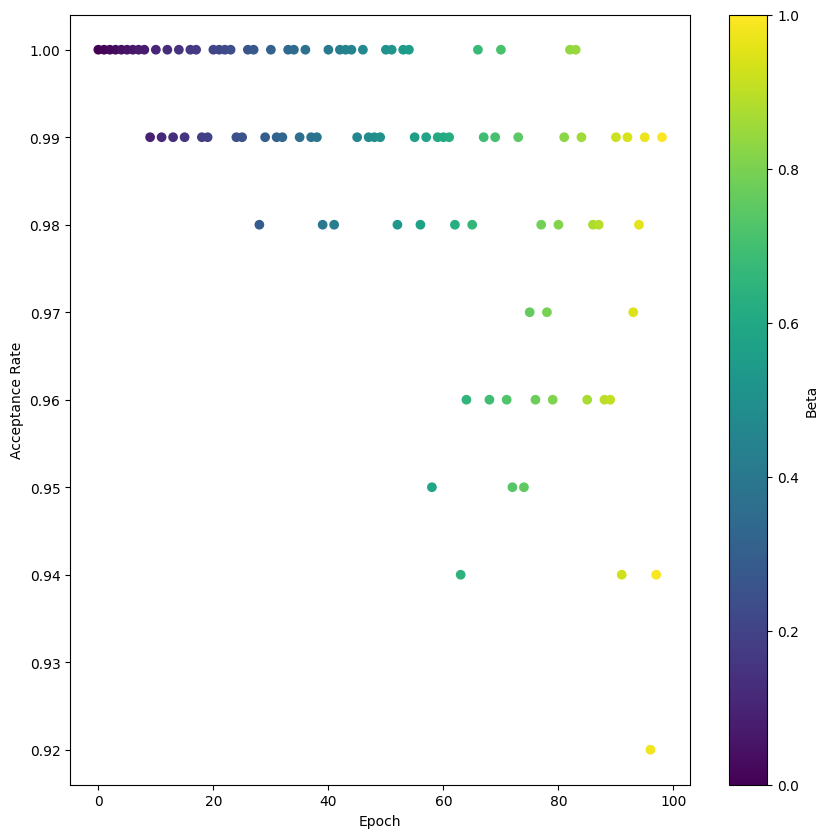

In [15]:

cmap = cm.viridis
norm = plt.Normalize(min(hist_df.Beta), max(hist_df.Beta))
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)

scatter = ax.scatter(hist_df.Epoch, hist_df.Acceptance_rate, c=hist_df.Beta, cmap=cmap)
ax.set_xlabel('Epoch')
ax.set_ylabel('Acceptance Rate')

# Add colorbar without normalization
fig.colorbar(sm, ax=ax, label='Beta')

plt.show()
